In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import stats
from time import time
from iminuit import Minuit,cost
import ROOT
import pickle

Welcome to JupyROOT 6.28/04


### Define functions

In [2]:
### constants
NA = 6.02214076e23 # Avogadro constant (mol^{-1})

### probe particle (e.g. pi+)
m_probe = 139.57 # mass (MeV)

### target material (e.g. liquid argon)
rho_tar = 1.4 # density (g/cm^3)
M_tar = 39.95 # molar mass (g/mol)
n_tar = rho_tar*NA/M_tar # number density (cm^{-3})

usr_define_xs_curve_method = 2
if usr_define_xs_curve_method == 1: # use polynomial to define cross-section curves
    XS_gen_tot = np.poly1d([-2.689e-20, 1.880e-16, -5.497e-13, 8.701e-10, -8.047e-7, 4.358e-4, -1.298e-1, 1.783e1, 0])
    XS_gen_ex = np.poly1d([1.372e-20, -7.150e-17, 1.302e-13, -6.930e-11, -7.217e-8, 1.154e-4, -5.600e-2, 9.891, 0])
    XS_gen_oth = XS_gen_tot - XS_gen_ex
elif usr_define_xs_curve_method == 2: # use spline interpolation to define cross-section curves
    XS_gen_tot = CubicSpline(*np.transpose([[0,0], [50,500], [100,800], [150,900], [200,800], [250,750], [300,650], [400,600], [500,620], [600,630], [700,610], [800,600], [900,590], [1000,600], [1100,610], [1200,605], [1300,610], [1400,605], [1500,600]]))
    XS_gen_ex = CubicSpline(*np.transpose([[0,0], [50,200], [100,550], [150,650], [200,450], [250,350], [300,300], [400,250], [500,200], [600,220], [700,260], [800,300], [900,280], [1000,250], [1100,220], [1200,200], [1300,200], [1400,200], [1500,220]]))
    XS_gen_oth = lambda x: XS_gen_tot(x) - XS_gen_ex(x)

### dE/dx as a function of KE described by Bethe-Bloch formula
dEdx_BBx, dEdx_BBy = np.loadtxt("inputs/dEdx_mean.txt")
dEdx_mean = lambda KE: np.interp(KE, dEdx_BBx, dEdx_BBy) # input from external pi-Ar dE/dx curve

### dE/dx distribution with the mean value provided
dEdx_pdfx, dEdx_pdfy = np.loadtxt("inputs/dEdx_pdf.txt")
pvxx, dEdx_ppf_arr_1, dEdx_ppf_arr_2, dEdx_ppf_arr_3 = np.loadtxt("inputs/dEdx_ppf.txt")
test_KE_1 = 400
dEdx_ppf_landau = lambda KE: np.interp(KE, pvxx, dEdx_ppf_arr_1)
test_KE_2 = 20
dEdx_ppf_vavilov = lambda KE: np.interp(KE, pvxx, dEdx_ppf_arr_2)
test_KE_3 = 2
dEdx_ppf_gaussian = lambda KE: np.interp(KE, pvxx, dEdx_ppf_arr_3)
def dEdx_rdm(KE): # generate random value following the dE/dx distribution at a certain KE
    pv = np.random.rand() # a random number uniformly distributed in [0, 1]
    if KE > 83.85: # Landau
        return dEdx_ppf_landau(pv) + dEdx_mean(KE)-dEdx_mean(test_KE_1)
    if KE > 2.15: # Vavilov
        return dEdx_ppf_vavilov(pv) + dEdx_mean(KE)-dEdx_mean(test_KE_2)
    else: # Gaussian
        return dEdx_ppf_gaussian(pv) + dEdx_mean(KE)-dEdx_mean(test_KE_3)

### define true energy binning
true_bins = np.array([1000,950,900,850,800,750,700,650,600,550,500,450,400,350,300,250,200,150,100,50,0])
def set_bins(KEbins):
    Nbins = len(KEbins)
    cKE = (KEbins[:-1] + KEbins[1:])/2 # energy bin centers
    wKE = (KEbins[:-1] - KEbins[1:])/2 # energy bin half-width
    Nbins_3D = Nbins**3 # number of bins for the combined variable
    return Nbins, Nbins_3D, cKE, wKE
Ntruebins, Ntruebins_3D, true_cKE, true_wKE = set_bins(true_bins)

In [3]:
def if_interaction_step(KE, x_step): # whether the probe particle interacts with the material atom in a step
    
    Pint_ex = n_tar * XS_gen_ex(KE)/1e27 * x_step # possibility to have the signal interaction in a step
    Pint_oth = n_tar * XS_gen_oth(KE)/1e27 * x_step # possibility to have other interactions in a step
    
    judg = np.random.rand()
    if (judg < Pint_ex):
        return 1 # signal interaction
    elif (judg < Pint_ex+Pint_oth):
        return 2 # other interactions
    else:
        return 0 # no interaction

def interaction_sim(KE, x_step): # simulate step-by-step, until the probe interacts with the material atom or stops to rest
    flag = 0
    while flag == 0:
        flag = if_interaction_step(KE, x_step)
        dEdx = dEdx_rdm(KE)
        Edeposition = dEdx * x_step
        KE -= Edeposition
        if (KE <= 0):
            return 0, 0
    return KE, flag # the final energy of the probe particle; a flag indicating the type of interaction

def generate_true_sample(f_Nevts, f_x_step=0.1, f_trueKEi=None):
    if f_trueKEi is None:
        f_trueKEi = np.random.normal(900, 100, f_Nevts) # initial energy of all events
    elif (f_Nevts != len(f_trueKEi)):
        raise Exception("f_Nevts != len(f_trueKEi)")
    f_trueKEf = [] # final energy of all events
    f_int_type = [] # interaction type of all events
    
    for ievt in range(f_Nevts):
        if (ievt%(10000*f_x_step)==0):
            print(f"  processing events {ievt}/{f_Nevts}...")
        KE, flag = interaction_sim(f_trueKEi[ievt], f_x_step)
        f_trueKEf.append(KE)
        f_int_type.append(flag)
    
    f_trueKEf = np.array(f_trueKEf)
    print("Sample generated.")
    return f_trueKEi, f_trueKEf, f_int_type


def get_sliceID_histograms(f_KEi, f_KEf, f_int_type, KEbins):
    f_SIDini = []
    f_SIDend = []
    f_SIDint_ex = []
    f_Nevts = len(f_KEi)
    for ievt in range(f_Nevts):
        KE_ini = f_KEi[ievt]
        KE_end = f_KEf[ievt]
        intrcn = f_int_type[ievt]
        Nbins = len(KEbins)
        
        ## derive the initial slice ID
        for SID_ini in range(Nbins-1):
            if KEbins[SID_ini] < KE_ini:
                break
                
        ## derive the final slice ID
        for SID_end in range(Nbins-1):
            if KEbins[SID_end+1] < KE_end:
                break
        
        ## remove incomplete slices
        if SID_end < SID_ini:
            SID_ini = -1
            SID_end = -1
            
        ## derive the signal interaction slice ID
        SID_int_ex = SID_end
        if intrcn != 1:
            SID_int_ex = -1
            
        f_SIDini.append(SID_ini)
        f_SIDend.append(SID_end)
        f_SIDint_ex.append(SID_int_ex)
    return f_SIDini, f_SIDend, f_SIDint_ex


def derive_energy_histograms(f_SIDini, f_SIDend, f_SIDint_ex, Nbins, f_evtweight=None):
    if f_evtweight is None:
        f_evtweight = np.ones(len(f_SIDini))
    ### derive the initial, end, interaction histogram (do not use the null bin)
    f_Nini,_ = np.histogram(f_SIDini, bins=range(-1, Nbins), weights=f_evtweight)
    f_Nend,_ = np.histogram(f_SIDend, bins=range(-1, Nbins), weights=f_evtweight)
    f_Nint_ex,_ = np.histogram(f_SIDint_ex, bins=range(-1, Nbins), weights=f_evtweight)
    f_Nini = f_Nini[1:]
    f_Nend = f_Nend[1:]
    f_Nint_ex = f_Nint_ex[1:]
    
    ### derive the incident histogram
    f_Ninc = np.zeros_like(f_Nini)
    for ibin in range(Nbins-1): # again, the formula can be found in the reference below
        ## two equivalent way to calculate the incident histogram
        for itmp in range(0, ibin+1):
            f_Ninc[ibin] += f_Nini[itmp]
        for itmp in range(0, ibin):
            f_Ninc[ibin] -= f_Nend[itmp]
        '''for itmp in range(ibin, Nbins-1):
            f_Ninc[ibin] += f_Nend[itmp]
        for itmp in range(ibin+1, Nbins-1):
            f_Ninc[ibin] -= f_Nini[itmp]'''
    return f_Nini, f_Nend, f_Nint_ex, f_Ninc

def calculate_XS(f_true_Ninc, f_true_Nend, f_true_Nint_ex, Nbins):
    f_true_XS = np.zeros_like(f_true_Ninc)
    for ibin in range(Nbins-1):
        prefact = dEdx_mean(true_cKE[ibin]) / (n_tar*true_wKE[ibin]*2) * 1e27 # pre-factor
        Ninc = f_true_Ninc[ibin]
        Nend = f_true_Nend[ibin]
        Nint_ex = f_true_Nint_ex[ibin]
        
        if Nend == 0 or Ninc-Nend == 0: # no track ends in this bin, or all tracks end in this bin
            f_true_XS[ibin] = 0
        else:    
            f_true_XS[ibin] = prefact * Nint_ex/Nend * np.log(Ninc/(Ninc-Nend))
    return f_true_XS

def get_3D_histogram(f_Nevts, f_SIDini, f_SIDend, f_SIDint_ex, Nbins, f_evtweight=None):
    if f_evtweight is None:
        f_evtweight = np.ones(len(f_SIDini))
    Nbins_3D = Nbins**3
    f_N3D = np.zeros(Nbins_3D)
    f_N3D_err = np.zeros(Nbins_3D)
    f_SID3D = np.zeros(f_Nevts, dtype=np.int32)
    
    for ievt in range(f_Nevts): # fill in the combined variable
        SID_ini = f_SIDini[ievt] + 1 # so that null bin moves to 0 (covenient for integer division and modulus below)
        SID_end = f_SIDend[ievt] + 1
        SID_int_ex = f_SIDint_ex[ievt] + 1
        weight = f_evtweight[ievt]
        
        SID3D = SID_ini + Nbins * SID_end + Nbins*Nbins * SID_int_ex # definition of the combined variable
        f_SID3D[ievt] = SID3D
        
        f_N3D[SID3D] += weight
        f_N3D_err[SID3D] += weight*weight
        
    f_N3D_Vcov = np.diag(f_N3D_err) # this is a fill process. Each bin is independent, so the covariance matrix is diagonal
    return f_SID3D, f_N3D, f_N3D_Vcov


def get_Cov_3SID_from_N3D(f_N3D_Vcov, Nbins):
    Nbins_3D = Nbins**3
    Jac_N3D_3SID = np.zeros([3*Nbins, Nbins_3D])
    for jbin in range(Nbins_3D):
        ## use integer division and modulus to project back to 1D histograms
        ibx = jbin % Nbins # get SID_ini
        iby = (jbin // Nbins) % Nbins # get SID_end
        ibz = (jbin // Nbins // Nbins) % Nbins # get SID_int_ex
        Jac_N3D_3SID[ibx, jbin] = 1
        Jac_N3D_3SID[Nbins+iby, jbin] = 1
        Jac_N3D_3SID[2*Nbins+ibz, jbin] = 1
    
    ### derive the covariance matrix 3SID_Vcov
    #f_3SID_Vcov = np.einsum("ij,jk,lk->il", Jac_N3D_3SID, f_N3D_Vcov, Jac_N3D_3SID) # computation too slow
    f_3SID_Vcov = np.einsum("ij,jk->ik", Jac_N3D_3SID, f_N3D_Vcov)
    f_3SID_Vcov = np.einsum("ij,kj->ik", f_3SID_Vcov, Jac_N3D_3SID)
    return f_3SID_Vcov

def get_Cov_3N_from_3SID(f_3SID_Vcov, Nbins):
    Jac_3SID_3N = np.zeros([3*(Nbins-1), 3*Nbins])
    for ibin in range(Nbins-1): # for Ninc
        ## two equivalent way to calculate the incident histogram
        for jbin in range(ibin+2, Nbins):
            Jac_3SID_3N[ibin, jbin] = -1
        for jbin in range(ibin+1+Nbins, 2*Nbins):
            Jac_3SID_3N[ibin, jbin] = 1
        '''for jbin in range(1, ibin+2):
            Jac_3SID_3N[ibin, jbin] = 1
        for jbin in range(1+Nbins, ibin+1+Nbins):
            Jac_3SID_3N[ibin, jbin] = -1'''
    for ibin in range(Nbins-1, 2*(Nbins-1)): # for Nend
        Jac_3SID_3N[ibin, ibin+2] = 1
    for ibin in range(2*(Nbins-1), 3*(Nbins-1)): # for Nint_ex
        Jac_3SID_3N[ibin, ibin+3] = 1
    
    ### derive the covariance matrix 3N_Vcov
    f_3N_Vcov = np.einsum("ij,jk,lk->il", Jac_3SID_3N, f_3SID_Vcov, Jac_3SID_3N)
    return f_3N_Vcov

def calculate_XS_Cov_from_3N(f_Ninc, f_Nend, f_Nint_ex, f_3N_Vcov, KEbins):
    Nbins, _, cKE, wKE = set_bins(KEbins)
    f_XS = np.zeros_like(f_Ninc)
    Jac_3N_XS = np.zeros([Nbins-1, 3*(Nbins-1)])
    for ibin in range(Nbins-1):
        prefact = dEdx_mean(cKE[ibin]) / (n_tar*wKE[ibin]*2) * 1e27 # pre-factor
        Ninc = f_Ninc[ibin]
        Nend = f_Nend[ibin]
        Nint_ex = f_Nint_ex[ibin]
        
        if Nend <= 0 or Ninc-Nend <= 0: # no track ends in this bin, or all tracks end in this bin
            f_XS[ibin] = 0
            Jac_3N_XS[ibin, ibin] = 0
            Jac_3N_XS[ibin, ibin+Nbins-1] = 0
            Jac_3N_XS[ibin, ibin+2*(Nbins-1)] = 0
        else:
            f_XS[ibin] = prefact * Nint_ex/Nend * np.log(Ninc/(Ninc-Nend)) # same as above when we calculate the signal cross-section σ 
            Jac_3N_XS[ibin, ibin] = prefact * Nint_ex / Ninc / (Nend-Ninc) # ∂σ/∂Ninc
            Jac_3N_XS[ibin, ibin+Nbins-1] = prefact * Nint_ex/Nend * (1/(Ninc-Nend) - 1/Nend*np.log(Ninc/(Ninc-Nend))) # ∂σ/∂Nend
            Jac_3N_XS[ibin, ibin+2*(Nbins-1)] = prefact * 1 / Nend *np.log(Ninc/(Ninc-Nend)) # ∂σ/∂Nint_ex
    
    ### derive the covariance matrix XS_Vcov
    f_XS_Vcov = np.einsum("ij,jk,lk->il", Jac_3N_XS, f_3N_Vcov, Jac_3N_XS)
    return f_XS, f_XS_Vcov


### Generate simultaion sample

In [4]:
### Simulation true values
Nevts=4000000
x_step=0.1
evtweight=np.ones(Nevts)

trueKEi, trueKEf, int_type = generate_true_sample(Nevts, x_step, f_trueKEi=np.random.normal(900, 100, Nevts))
true_SIDini, true_SIDend, true_SIDint_ex = get_sliceID_histograms(trueKEi, trueKEf, int_type, true_bins)
true_Nini, true_Nend, true_Nint_ex, true_Ninc = derive_energy_histograms(true_SIDini, true_SIDend, true_SIDint_ex, Ntruebins, evtweight)

true_SID3D, true_N3D, true_N3D_Vcov = get_3D_histogram(Nevts, true_SIDini, true_SIDend, true_SIDint_ex, Ntruebins, evtweight)
true_3SID_Vcov = get_Cov_3SID_from_N3D(true_N3D_Vcov, Ntruebins)
true_3N_Vcov = get_Cov_3N_from_3SID(true_3SID_Vcov, Ntruebins)
true_XS, true_XS_Vcov = calculate_XS_Cov_from_3N(true_Ninc, true_Nend, true_Nint_ex, true_3N_Vcov, true_bins)


  processing events 0/4000000...
  processing events 1000/4000000...
  processing events 2000/4000000...
  processing events 3000/4000000...
  processing events 4000/4000000...
  processing events 5000/4000000...
  processing events 6000/4000000...
  processing events 7000/4000000...
  processing events 8000/4000000...
  processing events 9000/4000000...
  processing events 10000/4000000...
  processing events 11000/4000000...
  processing events 12000/4000000...
  processing events 13000/4000000...
  processing events 14000/4000000...
  processing events 15000/4000000...
  processing events 16000/4000000...
  processing events 17000/4000000...
  processing events 18000/4000000...
  processing events 19000/4000000...
  processing events 20000/4000000...
  processing events 21000/4000000...
  processing events 22000/4000000...
  processing events 23000/4000000...
  processing events 24000/4000000...
  processing events 25000/4000000...
  processing events 26000/4000000...
  processing e

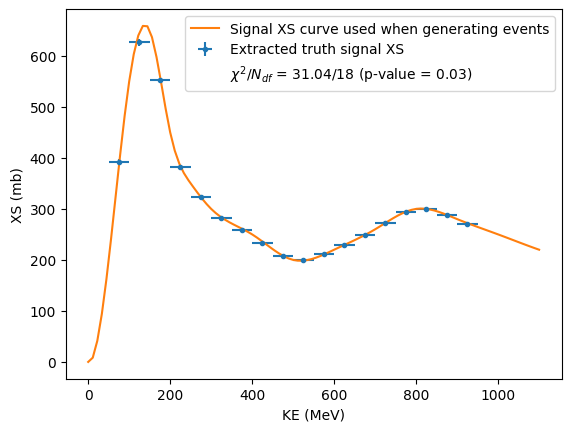

In [5]:
XS_x = true_cKE[1:-1] # the underflow and overflow bin are not used
XS_y = true_XS[1:-1]
XS_xerr = true_wKE[1:-1]
XS_yerr = np.sqrt(np.diagonal(true_XS_Vcov))[1:-1] # get the uncertainty from the covariance matrix
plt.errorbar(XS_x, XS_y, XS_yerr, XS_xerr, fmt=".", label="Extracted truth signal XS")
xx = np.linspace(0, 1100, 100)
plt.plot(xx,XS_gen_ex(xx), label="Signal XS curve used when generating events")
plt.xlabel("KE (MeV)")
plt.ylabel("XS (mb)") # 1 mb = 10^{-27} cm^2

### calculate chi^2
XS_diff = XS_y - XS_gen_ex(XS_x)
inv_true_XS_Vcov = np.linalg.pinv(true_XS_Vcov[1:-1, 1:-1])
chi2 = np.einsum("i,ij,j->", XS_diff, inv_true_XS_Vcov, XS_diff)
plt.plot([], [], ' ', label=rf"$\chi^2/N_{{df}}$ = {chi2:.2f}/{len(XS_diff)} (p-value = {1-stats.chi2.cdf(chi2, len(XS_diff)):.2f})") # print chi2 result

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

In [6]:
meas_bins = np.array([1000,950,900,850,800,750,700,650,600,550,500,450,400,350,300,250,200,150,100,50,0])
Nmeasbins = len(meas_bins)

def generate_measured_sample(f_Nevts, f_trueKEi, f_trueKEf, f_int_type, f_evtweight=None):
    if f_evtweight is None:
        f_evtweight = np.ones(f_Nevts)
    # user-defined
    f_parscore = np.random.normal(0.4, 0.6, f_Nevts) # used for beam particle selection (select > 1) # TB add bkg events with another random generator
    f_parscore += np.log(f_trueKEi-f_trueKEf)/10 # In general, the selection efficiency is not uniform. Making it depend on log(trueKEi-trueKEf), so that the efficiency is smaller for too short tracks, and larger if the tracks are long enough. 
    confus_mat_int_type = np.array([[0.8,0.1,0.1], [0.1,0.7,0.2], [0.05,0.3,0.65]]) # (0, 1, 2) == (no interaction, signal interaction, other interactions)
    
    f_measKEi = f_trueKEi[f_parscore>1]
    f_measKEf = f_trueKEf[f_parscore>1]
    f_selevt_weight = f_evtweight[f_parscore>1]
    f_Nselected_true_evts = len(f_measKEi)
    print(f"{f_Nselected_true_evts} events pass selections out of {f_Nevts} true events.")
    blurKEi = np.random.normal(-10, 80, f_Nselected_true_evts) # MeV
    blurKEf = np.random.normal(10, 60, f_Nselected_true_evts) # MeV
    f_measKEi += blurKEi
    f_measKEf += (blurKEi + blurKEf)
    f_measKEf = np.maximum(0, f_measKEf) # in case of negative measured KEf

    f_meas_int_type = np.array(f_int_type)[f_parscore>1]
    tmp_rdm = np.random.rand(f_Nselected_true_evts)
    f_confus_mat_int_type_mc = np.zeros([3,3])
    for ievt in range(f_Nselected_true_evts):
        if f_meas_int_type[ievt] == 0:
            if tmp_rdm[ievt] < confus_mat_int_type[0,0]:
                f_confus_mat_int_type_mc[0,0] += 1
            elif tmp_rdm[ievt] < sum(confus_mat_int_type[0,0:-1]):
                f_meas_int_type[ievt] = 1
                f_confus_mat_int_type_mc[0,1] += 1
            else:
                f_meas_int_type[ievt] = 2
                f_confus_mat_int_type_mc[0,2] += 1
        elif f_meas_int_type[ievt] == 1:
            if tmp_rdm[ievt] < confus_mat_int_type[1,0]:
                f_meas_int_type[ievt] = 0
                f_confus_mat_int_type_mc[1,0] += 1
            elif tmp_rdm[ievt] < sum(confus_mat_int_type[1,0:-1]):
                f_confus_mat_int_type_mc[1,1] += 1
            else:
                f_meas_int_type[ievt] = 2
                f_confus_mat_int_type_mc[1,2] += 1
        elif f_meas_int_type[ievt] == 2:
            if tmp_rdm[ievt] < confus_mat_int_type[2,0]:
                f_meas_int_type[ievt] = 0
                f_confus_mat_int_type_mc[2,0] += 1
            elif tmp_rdm[ievt] < sum(confus_mat_int_type[2,0:-1]):
                f_meas_int_type[ievt] = 1
                f_confus_mat_int_type_mc[2,1] += 1
            else:
                f_confus_mat_int_type_mc[2,2] += 1
        else:
            raise Exception("Interaction type not in [0, 1, 2]!")
    return f_Nselected_true_evts, f_measKEi, f_measKEf, f_meas_int_type, f_selevt_weight, f_parscore


def map_index_to_combined_variable(f_N3D, f_N3D_err, Nbins):
    Nbins_3D = Nbins**3
    ### mapping index from 3D to 1D
    f_3D1D_map = np.zeros(Nbins_3D, dtype=np.int32)
    tmpidx = 0
    for ibin in range(Nbins_3D):
        if f_N3D[ibin] > 0:
            tmpidx += 1
            f_3D1D_map[ibin] = tmpidx
    
    f_N1D = f_N3D[f_N3D>0]
    f_N1D_err = f_N3D_err[f_N3D>0]
    Nbins_1D = len(f_N1D)
    return f_3D1D_map, f_N1D, f_N1D_err, Nbins_1D

def get_efficiency(f_true_N3D, f_true_N1D, f_true_SID3D, Nbins_3D, f_parscore):
    f_true_SID3D_sel = f_true_SID3D[f_parscore>1] # TB moved to somewhere before
    f_true_N3D_sel, _ = np.histogram(f_true_SID3D_sel, bins=np.arange(Nbins_3D+1))

    f_eff1D = f_true_N3D_sel[f_true_N3D>0]/f_true_N1D
    f_eff1D_err = f_eff1D # TB considered efficiency uncertainty
    return f_eff1D, f_eff1D_err, f_true_SID3D_sel

def get_response_matrix(f_Nevt, f_Nmeasbins, f_Ntruebins, f_meas_hist, f_true_hist):
    f_response = ROOT.RooUnfoldResponse(f_Nmeasbins, 1, f_Nmeasbins+1, f_Ntruebins, 1, f_Ntruebins+1) # 1D index starts from 1
    for ievt in range(f_Nevt):
        f_response.Fill(f_meas_hist[ievt], f_true_hist[ievt])
    f_response_matrix = np.zeros([f_Ntruebins, f_Nmeasbins])
    for ibin in range(f_Ntruebins):
        for jbin in range(f_Nmeasbins):
            f_response_matrix[ibin, jbin] = f_response.Hresponse().GetBinContent(jbin+1, ibin+1)
    return f_response_matrix, f_response

In [7]:
### Simulate measured values
Nselected_true_evts, measKEi, measKEf, meas_int_type, selevt_weight, parscore = generate_measured_sample(Nevts, trueKEi, trueKEf, int_type, evtweight)
meas_SIDini, meas_SIDend, meas_SIDint_ex = get_sliceID_histograms(measKEi, measKEf, meas_int_type, meas_bins)
meas_SID3D, meas_N3D, meas_N3D_Vcov = get_3D_histogram(Nselected_true_evts, meas_SIDini, meas_SIDend, meas_SIDint_ex, Nmeasbins, selevt_weight)

true_3D1D_map, true_N1D, true_N1D_err, Ntruebins_1D = map_index_to_combined_variable(true_N3D, np.sqrt(np.diag(true_N3D_Vcov)), Ntruebins)
meas_3D1D_map, meas_N1D, meas_N1D_err, Nmeasbins_1D = map_index_to_combined_variable(meas_N3D, np.sqrt(np.diag(meas_N3D_Vcov)), Nmeasbins)

eff1D, eff1D_err, true_SID3D_sel = get_efficiency(true_N3D, true_N1D, true_SID3D, Ntruebins_3D, parscore)
response_matrix, response = get_response_matrix(Nselected_true_evts, Nmeasbins_1D, Ntruebins_1D, meas_3D1D_map[meas_SID3D], true_3D1D_map[true_SID3D_sel])


1635408 events pass selections out of 4000000 true events.


### Generate fake data sample

In [8]:
def map_data_to_MC_bins(f_N3D, f_N3D_err, f_3D1D_map):
    Nbins_3D = len(f_3D1D_map)
    for ibin in range(Nbins_3D):
        if f_N3D[ibin] > 0 and f_3D1D_map[ibin] == 0:
            print("Not empty in data but empty in MC.")
    f_N1D = f_N3D[f_3D1D_map>0]
    f_N1D_err = f_N3D_err[f_3D1D_map>0]
    return f_N1D, f_N1D_err
def generate_data_sample(Nevts, x_step, meas_bins, f_3D1D_map, evtweight=None):
    trueKEi, trueKEf, int_type = generate_true_sample(Nevts, x_step, f_trueKEi=np.random.normal(900, 100, Nevts))
    Nselected_true_evts, measKEi, measKEf, meas_int_type, selevt_weight, parscore = generate_measured_sample(Nevts, trueKEi, trueKEf, int_type, evtweight)
    meas_SIDini, meas_SIDend, meas_SIDint_ex = get_sliceID_histograms(measKEi, measKEf, meas_int_type, meas_bins)
    Nmeasbins = len(meas_bins)
    meas_SID3D, meas_N3D, meas_N3D_Vcov = get_3D_histogram(Nselected_true_evts, meas_SIDini, meas_SIDend, meas_SIDint_ex, Nmeasbins, selevt_weight)
    meas_N1D, meas_N1D_err = map_data_to_MC_bins(meas_N3D, np.sqrt(np.diag(meas_N3D_Vcov)), f_3D1D_map)
    return meas_N1D, np.diag(meas_N1D_err*meas_N1D_err)

Ndata_before_selection = 10000
data_meas_N1D, data_meas_V1D = generate_data_sample(Ndata_before_selection, x_step, meas_bins, meas_3D1D_map)
Ndata = sum(data_meas_N1D)
data_MC_scale = Ndata/Nselected_true_evts
print("Number of data events measured:", Ndata)

  processing events 0/10000...
  processing events 1000/10000...
  processing events 2000/10000...
  processing events 3000/10000...
  processing events 4000/10000...
  processing events 5000/10000...
  processing events 6000/10000...
  processing events 7000/10000...
  processing events 8000/10000...
  processing events 9000/10000...
Sample generated.
4073 events pass selections out of 10000 true events.
Number of data events measured: 4073.0


In [9]:
def unfolding(f_data_meas_N1D, f_data_meas_V1D, f_response, Nmeasbins, Ntruebins, niter=4):
    hMeas = ROOT.TH1D ("hmeas", "", Nmeasbins, 0, Nmeasbins)
    for ibin in range(Nmeasbins):
        hMeas.SetBinContent(ibin+1, f_data_meas_N1D[ibin])
    
    uf = ROOT.RooUnfoldBayes(f_response, hMeas, niter=niter)
    data_meas_V1D_TM = ROOT.TMatrix(Nmeasbins, Nmeasbins)
    for ibin in range(Nmeasbins):
        for jbin in range(Nmeasbins):
            data_meas_V1D_TM[ibin, jbin] = f_data_meas_V1D[ibin, jbin]
    uf.SetMeasuredCov(data_meas_V1D_TM)
    
    hUnfold = uf.Hunfold()
    VUnfold = uf.Eunfold()
    
    f_data_unfold = np.zeros(Ntruebins)
    f_data_unfold_cov = np.zeros([Ntruebins, Ntruebins])
    for ibin in range(Ntruebins):
        f_data_unfold[ibin] = hUnfold.GetBinContent(ibin+1)
        for jbin in range(Ntruebins):
            f_data_unfold_cov[ibin, jbin] = VUnfold[ibin, jbin]
    return f_data_unfold, f_data_unfold_cov

def efficiency_correct_1Dvar(f_data_unfold, f_data_unfold_cov, f_eff1D, f_true_3D1D_map, f_Ntruebins_3D, f_true_N3D, f_true_N3D_Vcov, f_data_MC_scale):
    f_unfd_N3D = np.zeros(f_Ntruebins_3D)
    f_unfd_N3D_Vcov = np.zeros([f_Ntruebins_3D, f_Ntruebins_3D])
    for ibin in range(f_Ntruebins_3D):
        if f_true_3D1D_map[ibin] > 0:
            if f_data_unfold[f_true_3D1D_map[ibin]-1] > 0:
                f_unfd_N3D[ibin] = f_data_unfold[f_true_3D1D_map[ibin]-1] / f_eff1D[f_true_3D1D_map[ibin]-1]
                for jbin in range(f_Ntruebins_3D):
                    if f_true_3D1D_map[jbin] > 0 and f_data_unfold[f_true_3D1D_map[jbin]-1] > 0:
                        f_unfd_N3D_Vcov[ibin, jbin] = f_data_unfold_cov[f_true_3D1D_map[ibin]-1, f_true_3D1D_map[jbin]-1] / (f_eff1D[f_true_3D1D_map[ibin]-1]*f_eff1D[f_true_3D1D_map[jbin]-1])
            elif f_eff1D[f_true_3D1D_map[ibin]-1] == 0:
                #print(data_unfold[true_3D1D_map[ibin]-1], true_N1D[true_3D1D_map[ibin]-1])
                f_unfd_N3D[ibin] = f_true_N3D[ibin]*f_data_MC_scale
                f_unfd_N3D_Vcov[ibin, ibin] = f_true_N3D_Vcov[ibin, ibin]*f_data_MC_scale*f_data_MC_scale
    f_unfd_N3D_err = np.sqrt(np.diag(f_unfd_N3D_Vcov))
    return f_unfd_N3D, f_unfd_N3D_Vcov

def get_unfold_histograms(f_unfd_N3D, f_Ntruebins):
    f_unfd_N3D_real3D = np.reshape(f_unfd_N3D, [f_Ntruebins, f_Ntruebins, f_Ntruebins])
    f_unfd_Nini = f_unfd_N3D_real3D.sum((0,1))[1:]
    f_unfd_Nend = f_unfd_N3D_real3D.sum((0,2))[1:]
    f_unfd_Nint_ex = f_unfd_N3D_real3D.sum((1,2))[1:]
    f_unfd_Ninc = np.zeros_like(f_unfd_Nini)
    for ibin in range(f_Ntruebins-1):
        ## two equivalent way to calculate the incident histogram
        for itmp in range(0, ibin+1):
            f_unfd_Ninc[ibin] += f_unfd_Nini[itmp]
        for itmp in range(0, ibin):
            f_unfd_Ninc[ibin] -= f_unfd_Nend[itmp]
        '''for itmp in range(ibin, f_Ntruebins-1):
            f_unfd_Ninc[ibin] += f_unfd_Nend[itmp]
        for itmp in range(ibin+1, f_Ntruebins-1):
            f_unfd_Ninc[ibin] -= f_unfd_Nini[itmp]'''
    return f_unfd_Nini, f_unfd_Nend, f_unfd_Nint_ex, f_unfd_Ninc

#### Measure cross section on the fake data sample using response matrix and efficiency plot modeled by the simulation sample

In [10]:
data_unfold, data_unfold_cov = unfolding(data_meas_N1D, data_meas_V1D, response, Nmeasbins_1D, Ntruebins_1D, niter=10)
unfd_N3D, unfd_N3D_Vcov = efficiency_correct_1Dvar(data_unfold, data_unfold_cov, eff1D, true_3D1D_map, Ntruebins_3D, true_N3D, true_N3D_Vcov, data_MC_scale)
unfd_Nini, unfd_Nend, unfd_Nint_ex, unfd_Ninc = get_unfold_histograms(unfd_N3D, Ntruebins)

unfd_3SID_Vcov = get_Cov_3SID_from_N3D(unfd_N3D_Vcov, Nmeasbins)
unfd_3N_Vcov = get_Cov_3N_from_3SID(unfd_3SID_Vcov, Nmeasbins)
unfd_XS, unfd_XS_Vcov = calculate_XS_Cov_from_3N(unfd_Ninc, unfd_Nend, unfd_Nint_ex, unfd_3N_Vcov, meas_bins)

Now unfolding...
Iteration : 0
Chi^2 of change 5.11724
Iteration : 1
Chi^2 of change 1.83628
Iteration : 2
Chi^2 of change 1.35919
Iteration : 3
Chi^2 of change 0.913972
Iteration : 4
Chi^2 of change 0.748696
Iteration : 5
Chi^2 of change 0.63483
Iteration : 6
Chi^2 of change 0.563709
Iteration : 7
Chi^2 of change 0.513572
Iteration : 8
Chi^2 of change 0.475452
Iteration : 9
Chi^2 of change 0.440771
Calculating covariances due to number of measured events
Calculating covariances due to number of measured events


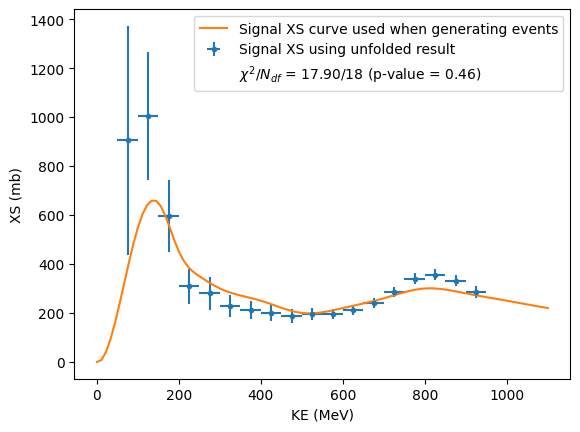

[  446.41766298   286.39386025   330.97254706   355.82286152
   340.37103892   286.93857192   240.04894094   211.15544539
   195.5571269    195.77357535   187.45525658   198.45448618
   211.57278575   227.38709926   279.62676667   308.13303441
   594.39741406  1004.27046833   905.11748883 26269.46089964]
[ 69.86985422  24.92109927  22.80232563  22.27183626  21.24229368
  19.89791845  19.13420673  19.67073108  21.29210805  24.88400238
  27.81991247  32.75053947  37.86994725  45.69905051  67.90823356
  73.22078893 147.1608847  261.99181505 467.30917281          nan]


/var/folders/xk/87tb0s5506b1_cd1jnk_jm9c0000gn/T/ipykernel_94591/108166754.py:24: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(np.diagonal(unfd_XS_Vcov)))


In [11]:
### plot unfd_XS
XS_x = true_cKE[1:-1] # the underflow and overflow bin are not used
XS_y = unfd_XS[1:-1]
XS_xerr = true_wKE[1:-1]
XS_yerr = np.sqrt(np.diagonal(unfd_XS_Vcov)[1:-1]) # get the uncertainty from the covariance matrix
plt.errorbar(XS_x, XS_y, XS_yerr, XS_xerr, fmt=".", label="Signal XS using unfolded result")
xx = np.linspace(0, 1100, 100)
plt.plot(xx,XS_gen_ex(xx), label="Signal XS curve used when generating events")
plt.xlabel("KE (MeV)")
plt.ylabel("XS (mb)") # 1 mb = 10^{-27} cm^2

### calculate chi^2
XS_diff = XS_y - XS_gen_ex(XS_x)
inv_unfd_XS_Vcov = np.linalg.pinv(unfd_XS_Vcov[1:-1, 1:-1])
chi2 = np.einsum("i,ij,j->", XS_diff, inv_unfd_XS_Vcov, XS_diff)
#print(f"Chi2 ignoring correlations is {sum(XS_diff*XS_diff/np.diag(unfd_XS_Vcov)[1:-1]):.2f}/{len(XS_diff)}={sum(XS_diff*XS_diff/np.diag(unfd_XS_Vcov)[1:-1])/len(XS_diff):.2f}" )
plt.plot([], [], ' ', label=rf"$\chi^2/N_{{df}}$ = {chi2:.2f}/{len(XS_diff)} (p-value = {1-stats.chi2.cdf(chi2, len(XS_diff)):.2f})") # print chi2 result

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()
print(unfd_XS)
print(np.sqrt(np.diagonal(unfd_XS_Vcov)))

### Toy studies

In [12]:
XS_true = []
XS_iter2 = []
XS_iter4 = []
XS_iter10 = []
XS_iter100 = []
XS_iter300 = []
XScov_true = []
XScov_iter2 = []
XScov_iter4 = []
XScov_iter10 = []
XScov_iter100 = []
XScov_iter300 = []
def cal_chi2(XS_true, XS_y, unfd_XS_Vcov):
    XS_diff = XS_y - XS_true
    inv_unfd_XS_Vcov = np.linalg.pinv(unfd_XS_Vcov)
    chi2 = np.einsum("i,ij,j->", XS_diff, inv_unfd_XS_Vcov, XS_diff)
    return chi2

#### Run simulation toys and save

In [13]:
### simulation toys
for i in range(400):
    print(f'{i} toy')
    Nevts_toy = 10000
    trueKEi_toy = trueKEi[i*Nevts_toy:i*Nevts_toy+Nevts_toy]
    trueKEf_toy = trueKEf[i*Nevts_toy:i*Nevts_toy+Nevts_toy]
    int_type_toy = int_type[i*Nevts_toy:i*Nevts_toy+Nevts_toy]
    evtweight_toy = evtweight[i*Nevts_toy:i*Nevts_toy+Nevts_toy]
    
    true_SIDini, true_SIDend, true_SIDint_ex = get_sliceID_histograms(trueKEi_toy, trueKEf_toy, int_type_toy, true_bins)
    true_Nini, true_Nend, true_Nint_ex, true_Ninc = derive_energy_histograms(true_SIDini, true_SIDend, true_SIDint_ex, Ntruebins, evtweight_toy)
    true_SID3D, true_N3D, true_N3D_Vcov = get_3D_histogram(Nevts_toy, true_SIDini, true_SIDend, true_SIDint_ex, Ntruebins, evtweight_toy)
    true_3SID_Vcov = get_Cov_3SID_from_N3D(true_N3D_Vcov, Ntruebins)
    true_3N_Vcov = get_Cov_3N_from_3SID(true_3SID_Vcov, Ntruebins)
    true_XS, true_XS_Vcov = calculate_XS_Cov_from_3N(true_Ninc, true_Nend, true_Nint_ex, true_3N_Vcov, true_bins)
    XS_true.append(true_XS[1:-1])
    XScov_true.append(true_XS_Vcov[1:-1, 1:-1])
    

0 toy
1 toy
2 toy
3 toy
4 toy
5 toy
6 toy
7 toy
8 toy
9 toy
10 toy
11 toy
12 toy
13 toy
14 toy
15 toy
16 toy
17 toy
18 toy
19 toy
20 toy
21 toy
22 toy
23 toy
24 toy
25 toy
26 toy
27 toy
28 toy
29 toy
30 toy
31 toy
32 toy
33 toy
34 toy
35 toy
36 toy
37 toy
38 toy
39 toy
40 toy
41 toy
42 toy
43 toy
44 toy
45 toy
46 toy
47 toy
48 toy
49 toy
50 toy
51 toy
52 toy
53 toy
54 toy
55 toy
56 toy
57 toy
58 toy
59 toy
60 toy
61 toy
62 toy
63 toy
64 toy
65 toy
66 toy
67 toy
68 toy
69 toy
70 toy
71 toy
72 toy
73 toy
74 toy
75 toy
76 toy
77 toy
78 toy
79 toy
80 toy
81 toy
82 toy
83 toy
84 toy
85 toy
86 toy
87 toy
88 toy
89 toy
90 toy
91 toy
92 toy
93 toy
94 toy
95 toy
96 toy
97 toy
98 toy
99 toy
100 toy
101 toy
102 toy
103 toy
104 toy
105 toy
106 toy
107 toy
108 toy
109 toy
110 toy
111 toy
112 toy
113 toy
114 toy
115 toy
116 toy
117 toy
118 toy
119 toy
120 toy
121 toy
122 toy
123 toy
124 toy
125 toy
126 toy
127 toy
128 toy
129 toy
130 toy
131 toy
132 toy
133 toy
134 toy
135 toy
136 toy
137 toy
138 to

In [14]:
true_toyXS = {"XS_true": XS_true, "XScov_true": XScov_true}
pickle.dump(true_toyXS, open("samples/true_toyXS.p", "wb"))

#### Run fake data toys and save

In [15]:
### fake data toys
for i in range(400):
    print(f'{i} toy')
    Ndata_before_selection = 10000
    data_meas_N1D, data_meas_V1D = generate_data_sample(Ndata_before_selection, x_step, meas_bins, meas_3D1D_map)
    Ndata = sum(data_meas_N1D)
    data_MC_scale = Ndata/Nselected_true_evts
    
    data_unfold, data_unfold_cov = unfolding(data_meas_N1D, data_meas_V1D, response, Nmeasbins_1D, Ntruebins_1D, niter=2)
    unfd_N3D, unfd_N3D_Vcov = efficiency_correct_1Dvar(data_unfold, data_unfold_cov, eff1D, true_3D1D_map, Ntruebins_3D, true_N3D, true_N3D_Vcov, data_MC_scale)
    unfd_Nini, unfd_Nend, unfd_Nint_ex, unfd_Ninc = get_unfold_histograms(unfd_N3D, Ntruebins)
    unfd_3SID_Vcov = get_Cov_3SID_from_N3D(unfd_N3D_Vcov, Nmeasbins)
    unfd_3N_Vcov = get_Cov_3N_from_3SID(unfd_3SID_Vcov, Nmeasbins)
    unfd_XS, unfd_XS_Vcov = calculate_XS_Cov_from_3N(unfd_Ninc, unfd_Nend, unfd_Nint_ex, unfd_3N_Vcov, meas_bins)
    XS_iter2.append(unfd_XS[1:-1])
    XScov_iter2.append(unfd_XS_Vcov[1:-1, 1:-1])
    
    data_unfold, data_unfold_cov = unfolding(data_meas_N1D, data_meas_V1D, response, Nmeasbins_1D, Ntruebins_1D, niter=4)
    unfd_N3D, unfd_N3D_Vcov = efficiency_correct_1Dvar(data_unfold, data_unfold_cov, eff1D, true_3D1D_map, Ntruebins_3D, true_N3D, true_N3D_Vcov, data_MC_scale)
    unfd_Nini, unfd_Nend, unfd_Nint_ex, unfd_Ninc = get_unfold_histograms(unfd_N3D, Ntruebins)
    unfd_3SID_Vcov = get_Cov_3SID_from_N3D(unfd_N3D_Vcov, Nmeasbins)
    unfd_3N_Vcov = get_Cov_3N_from_3SID(unfd_3SID_Vcov, Nmeasbins)
    unfd_XS, unfd_XS_Vcov = calculate_XS_Cov_from_3N(unfd_Ninc, unfd_Nend, unfd_Nint_ex, unfd_3N_Vcov, meas_bins)
    XS_iter4.append(unfd_XS[1:-1])
    XScov_iter4.append(unfd_XS_Vcov[1:-1, 1:-1])
    
    data_unfold, data_unfold_cov = unfolding(data_meas_N1D, data_meas_V1D, response, Nmeasbins_1D, Ntruebins_1D, niter=10)
    unfd_N3D, unfd_N3D_Vcov = efficiency_correct_1Dvar(data_unfold, data_unfold_cov, eff1D, true_3D1D_map, Ntruebins_3D, true_N3D, true_N3D_Vcov, data_MC_scale)
    unfd_Nini, unfd_Nend, unfd_Nint_ex, unfd_Ninc = get_unfold_histograms(unfd_N3D, Ntruebins)
    unfd_3SID_Vcov = get_Cov_3SID_from_N3D(unfd_N3D_Vcov, Nmeasbins)
    unfd_3N_Vcov = get_Cov_3N_from_3SID(unfd_3SID_Vcov, Nmeasbins)
    unfd_XS, unfd_XS_Vcov = calculate_XS_Cov_from_3N(unfd_Ninc, unfd_Nend, unfd_Nint_ex, unfd_3N_Vcov, meas_bins)
    XS_iter10.append(unfd_XS[1:-1])
    XScov_iter10.append(unfd_XS_Vcov[1:-1, 1:-1])

    data_unfold, data_unfold_cov = unfolding(data_meas_N1D, data_meas_V1D, response, Nmeasbins_1D, Ntruebins_1D, niter=100)
    unfd_N3D, unfd_N3D_Vcov = efficiency_correct_1Dvar(data_unfold, data_unfold_cov, eff1D, true_3D1D_map, Ntruebins_3D, true_N3D, true_N3D_Vcov, data_MC_scale)
    unfd_Nini, unfd_Nend, unfd_Nint_ex, unfd_Ninc = get_unfold_histograms(unfd_N3D, Ntruebins)
    unfd_3SID_Vcov = get_Cov_3SID_from_N3D(unfd_N3D_Vcov, Nmeasbins)
    unfd_3N_Vcov = get_Cov_3N_from_3SID(unfd_3SID_Vcov, Nmeasbins)
    unfd_XS, unfd_XS_Vcov = calculate_XS_Cov_from_3N(unfd_Ninc, unfd_Nend, unfd_Nint_ex, unfd_3N_Vcov, meas_bins)
    XS_iter100.append(unfd_XS[1:-1])
    XScov_iter100.append(unfd_XS_Vcov[1:-1, 1:-1])

    data_unfold, data_unfold_cov = unfolding(data_meas_N1D, data_meas_V1D, response, Nmeasbins_1D, Ntruebins_1D, niter=300)
    unfd_N3D, unfd_N3D_Vcov = efficiency_correct_1Dvar(data_unfold, data_unfold_cov, eff1D, true_3D1D_map, Ntruebins_3D, true_N3D, true_N3D_Vcov, data_MC_scale)
    unfd_Nini, unfd_Nend, unfd_Nint_ex, unfd_Ninc = get_unfold_histograms(unfd_N3D, Ntruebins)
    unfd_3SID_Vcov = get_Cov_3SID_from_N3D(unfd_N3D_Vcov, Nmeasbins)
    unfd_3N_Vcov = get_Cov_3N_from_3SID(unfd_3SID_Vcov, Nmeasbins)
    unfd_XS, unfd_XS_Vcov = calculate_XS_Cov_from_3N(unfd_Ninc, unfd_Nend, unfd_Nint_ex, unfd_3N_Vcov, meas_bins)
    XS_iter300.append(unfd_XS[1:-1])
    XScov_iter300.append(unfd_XS_Vcov[1:-1, 1:-1])

0 toy
  processing events 0/10000...
  processing events 1000/10000...
  processing events 2000/10000...
  processing events 3000/10000...
  processing events 4000/10000...
  processing events 5000/10000...
  processing events 6000/10000...
  processing events 7000/10000...
  processing events 8000/10000...
  processing events 9000/10000...
Sample generated.
4034 events pass selections out of 10000 true events.
1 toy
  processing events 0/10000...
  processing events 1000/10000...
  processing events 2000/10000...
  processing events 3000/10000...
  processing events 4000/10000...
  processing events 5000/10000...
  processing events 6000/10000...
  processing events 7000/10000...
  processing events 8000/10000...
  processing events 9000/10000...
Sample generated.
4122 events pass selections out of 10000 true events.
2 toy
  processing events 0/10000...
  processing events 1000/10000...
  processing events 2000/10000...
  processing events 3000/10000...
  processing events 4000/10000.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
unfd_toyXS = {"XS_iter2": XS_iter2,
             "XS_iter4": XS_iter4,
             "XS_iter10": XS_iter10,
             "XS_iter100": XS_iter100,
             "XS_iter300": XS_iter300,
             "XScov_iter2": XScov_iter2,
             "XScov_iter4": XScov_iter4,
             "XScov_iter10": XScov_iter10,
             "XScov_iter100": XScov_iter100,
             "XScov_iter300": XScov_iter300}
pickle.dump(unfd_toyXS, open("samples/unfd_toyXS.p", "wb"))

##### Below are some previous implementations I'm loath to delete for now. Don't read.

In [17]:
print(XScov_true)

[array([[ 2.86519096e+02,  5.50517324e-01,  1.51177891e+00,
         1.12119826e-01, -1.02007007e+00, -1.01003317e+00,
        -7.61280253e-02, -1.08921032e+00, -1.41571314e-01,
         5.14050654e-01,  6.17833357e-01,  3.95838771e+00,
         6.91997370e-01,  2.30798925e+00, -8.73756887e-01,
         2.83825114e+00, -1.38199689e+01, -7.53001189e+00],
       [ 5.50517324e-01,  2.19585167e+02,  2.56175522e-01,
         6.70978054e-01, -4.67476167e-01, -3.61657514e-01,
         4.51314657e-02, -7.12991978e-01, -6.94844852e-01,
        -3.90508760e-01,  7.33740849e-01,  2.53168117e+00,
         1.36575667e-01,  2.92255605e+00,  1.52416201e+00,
         4.06966555e+00, -1.00252496e+01, -1.75530313e+00],
       [ 1.51177891e+00,  2.56175522e-01,  1.77367399e+02,
         7.63400093e-01,  6.97109517e-02, -1.44589053e-01,
        -2.74538853e-01, -4.80970317e-01, -6.20719293e-01,
        -8.58436957e-01, -2.61671879e-01,  9.29287068e-01,
         1.77188440e-01,  2.57784235e+00, -9.19085261

In [73]:
print(chi2_true)
print(chi2_iter1)
print(chi2_iter4)
print(chi2_iter20)

[6.418716499638716, 14.0090266833043, 17.295650027431208, 28.100059584034494, 55.66747613611302, 23.897111395687187, 26.129241302666763, 31.65348559724736, 14.429972862170214, 20.550768947841043, 17.600890140471158, 23.999701173468395, 17.51842194755515, 31.893524597606866, 21.36953486135087, 19.29042939439147, 15.200027876598226, 17.963030418217755, 17.678694380902712, 22.709050935111208, 18.942534194116586, 31.978408553702067, 18.5170199694503, 25.26394503753133, 11.226694657788828, 10.818310117184895, 13.061376247085471, 11.998749910921193, 13.899166738312463, 10.601275103985776, 16.576986779538828, 28.257664943283206, 29.553284524471323, 22.824315884850506, 15.564224594102022, 10.469677090220554, 12.886976265620678, 19.004389009392746, 16.80847651557061, 19.182250291254924, 11.161083487844264, 11.635691167817388, 17.399842868183452, 10.549306921867927, 32.712754731604875, 9.936078376523291, 22.24239638299491, 25.253259740416926, 21.155740807372204, 13.659275030879128, 54.0781573990

[0.0017731957873435848, -0.006723068091850742, -0.24173745504729657, -0.00711540216133782, 0.2879963492224933, -0.029511352669211472, 0.10820996162007261, -0.11830318593228466, 0.09309882985517406, -0.015175538796485259, -0.07422330825142094, 0.0760808242311394, -0.10678684984262618, 0.14028996571580596, -0.1172297251579156, -0.05888851696820319, -0.06836710714987816, -0.011436899429920613]
[0.8621380922309955, 0.9942856397663798, 1.2014626192737907, 0.9543640418580378, 1.0276672448622102, 0.9523619872057826, 0.9887306791825541, 0.8953500818774573, 0.790382336742265, 0.8682258620851173, 1.0343295071007137, 1.0749282870052421, 1.3260880054575492, 1.1696576097622187, 1.0817325292625877, 0.9517734952406655, 1.1012709794200217, 1.0300511484399473]
-0.011436899429920613 1.0300511484399473


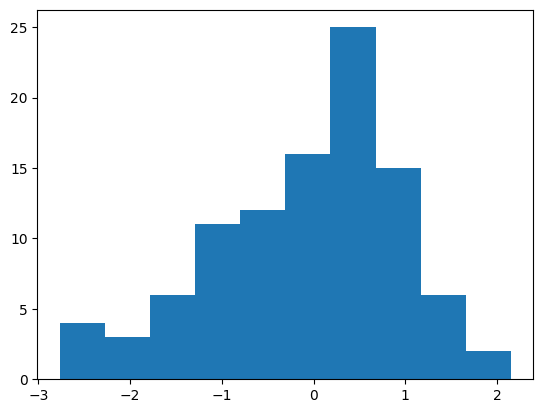

In [15]:
XS_test = XS_true
XScov_test = XScov_true
XSmean_test = np.mean(XS_test, axis=0)
#print(XSmean_test.tolist())
chi2_test = []
pull_test = []
for ii in range(len(XS_test)):
    xs = np.array(XS_test[ii])
    xscov = np.array(XScov_test[ii])
    chi2_test.append(cal_chi2(XS_gen_ex(true_cKE[1:-1]), xs, xscov))
    pull = (xs - XS_gen_ex(true_cKE[1:-1]))/np.sqrt(np.diag(xscov))
    #chi2_test.append(cal_chi2(XSmean_test, xs, xscov))
    #pull = (xs - XSmean_test)/np.sqrt(np.diag(xscov))
    pull_test.append(pull)
pull_test = np.array(pull_test)

def gauspdf(x, mu=0, sigma=1, con=1):
    return con*stats.norm.pdf(x, loc=mu, scale=sigma)
mmu = []
ssigma = []
mmu_err = []
ssigma_err = []
for ibin in range(len(pull_test[0])):
    pull = pull_test[:,ibin]
    bb, ed = np.histogram(pull)
    norm_fact = (ed[1]-ed[0])*len(pull)
    cLCS = cost.LeastSquares((ed[1:]+ed[:-1])/2, bb, np.maximum(np.sqrt(bb),1), gauspdf)
    mLCS = Minuit(cLCS, mu=0, sigma=1, con=norm_fact)
    mLCS.fixed["con"] = True
    mLCS.migrad()
    mLCS.hesse()
    mmu.append(mLCS.values['mu'])
    ssigma.append(mLCS.values['sigma'])
    mmu_err.append(mLCS.errors['mu'])
    ssigma_err.append(mLCS.errors['sigma'])
print(mmu)
print(ssigma)
ibin=17
plt.hist(pull_test[:,ibin])
print(mmu[ibin], ssigma[ibin])

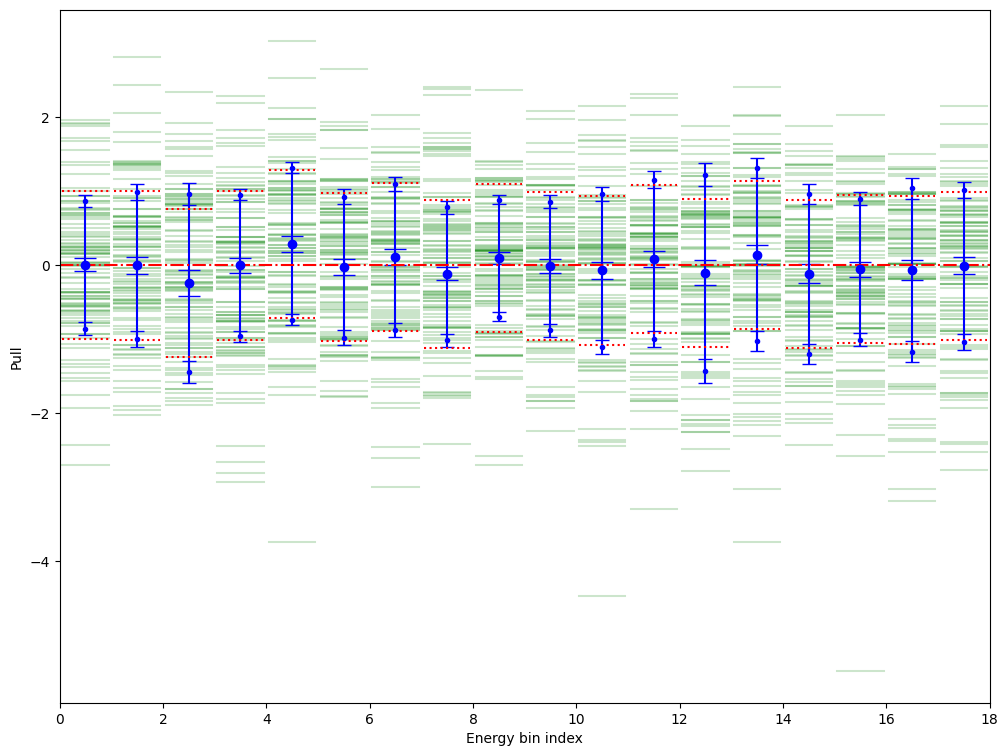

In [16]:
plt.figure(figsize=[12,9])
for ibin in range(len(pull_test[0])):
    for ievt in range(len(pull_test)):
        plt.plot([ibin+0.05,ibin+0.95], [pull_test[ievt,ibin]]*2, "g-", alpha=0.2)
    plt.errorbar(ibin+0.5, mmu[ibin], yerr=mmu_err[ibin], fmt="b.", capsize=8)
    plt.errorbar(ibin+0.5, mmu[ibin]+ssigma[ibin], yerr=ssigma_err[ibin], fmt="b.", capsize=5)
    plt.errorbar(ibin+0.5, mmu[ibin]-ssigma[ibin], yerr=ssigma_err[ibin], fmt="b.", capsize=5)
    plt.errorbar(ibin+0.5, mmu[ibin], yerr=ssigma[ibin], fmt="bo")
    plt.plot([ibin+0.05,ibin+0.95],[mmu[ibin]-1]*2,"r:")
    plt.plot([ibin+0.05,ibin+0.95],[mmu[ibin]+1]*2,"r:")
plt.plot([0,len(pull_test[0])],[0]*2,"r",linestyle='dashdot')
plt.xlim([0,len(pull_test[0])])
#plt.ylim([-3,3])
plt.xlabel("Energy bin index")
plt.ylabel("Pull")
plt.show()

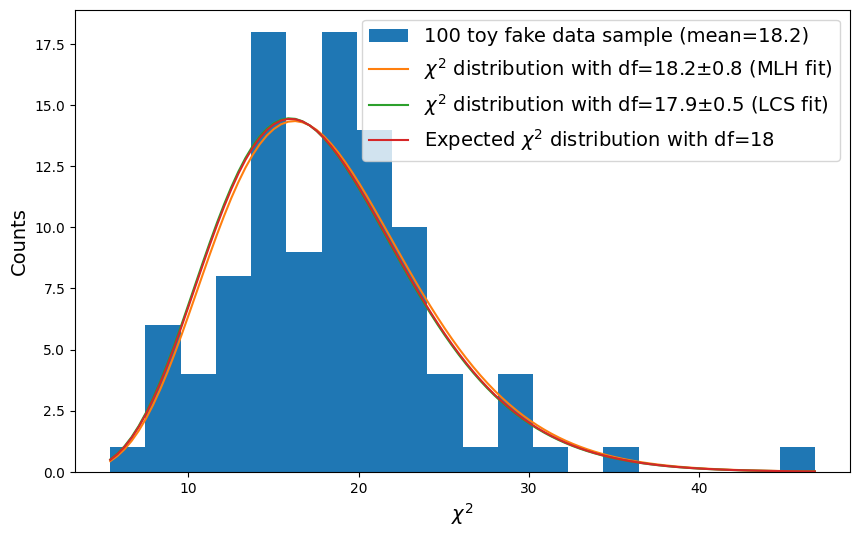

In [17]:
chi2 = np.array(chi2_test)
chi2 = chi2[chi2<100]
plt.figure(figsize=[10,6])
bb, ed, _ = plt.hist(chi2,bins=20,label=f"{len(chi2)} toy fake data sample (mean={np.mean(chi2):.1f})")
norm_fact = (ed[1]-ed[0])*len(chi2)
xxx = np.linspace(min(chi2), max(chi2), 100)

def chi2pdf(x, df, loc=0, scale=1, con=1):
    return con*stats.chi2.pdf(x, df=df, loc=0, scale=scale)
def fitChi2Hist(data, pdf, **kwargs): 
    data = np.array(data)
    def nll(df):
        return -np.sum(np.log(pdf(data, df, **kwargs)))
    m = Minuit(nll, df=len(XS_diff))
    m.migrad()
    m.hesse()
    return m
mMLH = fitChi2Hist(chi2, chi2pdf, con=norm_fact)

cLCS = cost.LeastSquares((ed[1:]+ed[:-1])/2, bb, np.maximum(np.sqrt(bb),1), chi2pdf)
mLCS = Minuit(cLCS, df=len(XS_diff), loc=0, scale=1, con=norm_fact)
mLCS.fixed["loc", "scale", "con"] = True
mLCS.migrad()
mLCS.hesse()

plt.xlabel(r"$\chi^2$", fontsize=14)
plt.ylabel("Counts", fontsize=14)
yyy = chi2pdf(xxx, df=mMLH.values["df"], con=norm_fact)
plt.plot(xxx, yyy, label=rf"$\chi^2$ distribution with df={mMLH.values['df']:.1f}$\pm${mMLH.errors['df']:.1f} (MLH fit)")
yyy = chi2pdf(xxx, df=mLCS.values["df"], con=norm_fact)
plt.plot(xxx, yyy, label=rf"$\chi^2$ distribution with df={mLCS.values['df']:.1f}$\pm${mLCS.errors['df']:.1f} (LCS fit)")
plt.plot(xxx, chi2pdf(xxx, df=len(XS_diff), con=norm_fact), label=rf"Expected $\chi^2$ distribution with df={len(XS_diff)}")
plt.legend(fontsize=14)
plt.show()

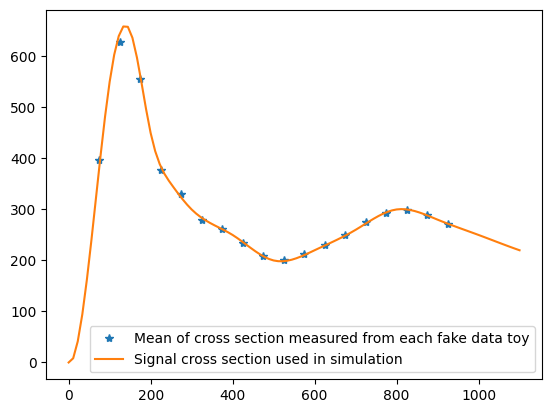

In [18]:
plt.plot(XS_x, XSmean_test, "*", label="Mean of cross section measured from each fake data toy")
xx = np.linspace(0, 1100, 100)
plt.plot(xx,XS_gen_ex(xx), label="Signal cross section used in simulation")
plt.legend()
plt.show()

In [19]:
savetoyxs = {"XS_true": XS_true,
             "XS_iter2": XS_iter2,
             "XS_iter4": XS_iter4,
             "XS_iter10": XS_iter10,
             "XScov_true": XScov_true,
             "XScov_iter2": XScov_iter2,
             "XScov_iter4": XScov_iter4,
             "XScov_iter10": XScov_iter10}
pickle.dump( savetoyxs, open( "toy1_evt1w_stepsize01.p", "wb" ) )